In [1]:
from IPython.display import Image, IFrame


# FUNDI TUTORIALS 2023

## An Introduction to SLURM & How to run jobs efficiently on the Hercules cluster

###                                                                                             By Vishnu Balakrishnan

# Prerequisites: How to log into the Hercules Cluster? 

## Start by editing your ssh config file (~/.ssh/config)

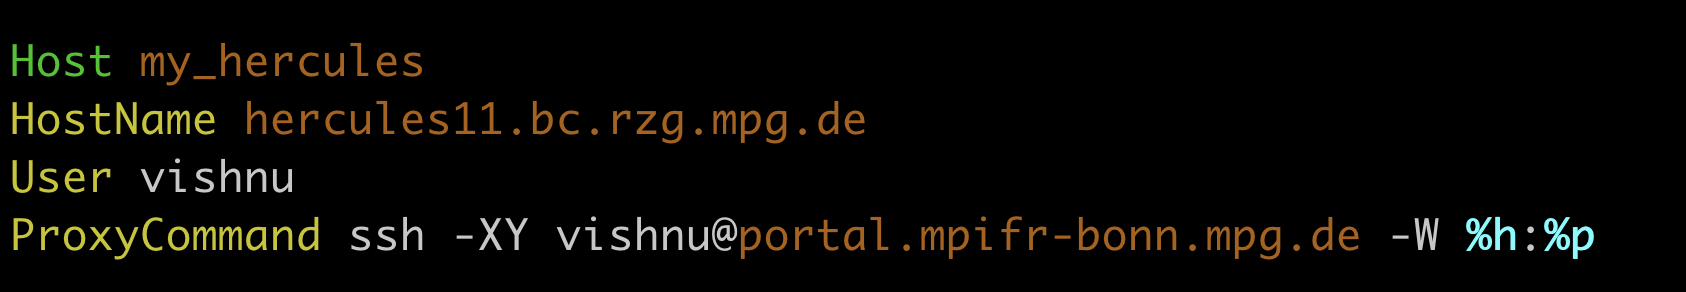

In [3]:
Image(filename='Images/ssh_config.png') 


**Load softwares like anaconda or git using the module environment**

module avail


---------------------------------------------------------------------------- /mpcdf/soft/CentOS_7/modules/third-party-compilers ----------------------------------------------------------------------------
clang/10.0  clang/11.1  clang/12

------------------------------------------------------------------------------------ /mpcdf/soft/CentOS_7/modules/java -------------------------------------------------------------------------------------
jdk/8.265  jdk/11.0.8  jdk/17.0.6

-------------------------------------------------------------------------------- /mpcdf/soft/CentOS_7/modules/visualization --------------------------------------------------------------------------------
blender/2.80  blender/2.93  blender/3.3  ffmpeg/3.4  ffmpeg/4.4  gnuplot/5.2  gnuplot/5.4  imagemagick/7.0  paraview/5.10  texlive/2021  turbovnc/2.2  visit/2.13  visit/2.13-mesa  visit/3.1.4  visit/3.3

------------------------------------------------------------------------------------- /mpcdf/soft/CentOS_7/modules/gpu -------------------------------------------------------------------------------------
cuda/10.2  cuda/11.0  cuda/11.2  cuda/11.4

------------------------------------------------------------------------------------- /mpcdf/soft/CentOS_7/modules/ml --------------------------------------------------------------------------------------
dal/2021.3  dal/2021.5

---------------------------------------------------------------------------------- /mpcdf/soft/CentOS_7/modules/compilers ----------------------------------------------------------------------------------
gcc/9  gcc/10  gcc/11  intel/19.1.3  intel/21.3.0  intel/21.5.0

----------------------------------------------------------------------------------- /mpcdf/soft/CentOS_7/modules/python ------------------------------------------------------------------------------------
anaconda/2/2019.03  anaconda/3/2020.02  anaconda/3/2021.05  anaconda/3/2021.11

------------------------------------------------------------------------------------ /mpcdf/soft/CentOS_7/modules/libs -------------------------------------------------------------------------------------
binutils/2.32  cgal/5.2  mkl/2020.4  mkl/2021.3  mkl/2022.0  tbb/2021.3  tbb/2021.5


------------------------------------------------------------------------------------------- MPCDF specific note --------------------------------------------------------------------------------------------
Not all modules are visible immediately, for most you first need to load their
prerequisites, see https://docs.mpcdf.mpg.de for more details. Typically those
are your compiler and/or MPI module of choice, as well your desired Python
stack, CUDA version, etc.

You can search in the full hierarchy of installed modules with

 find-module

(You can disable this hint by "export MPCDF_DISABLE_MODULE_AVAIL_HINT=1", e.g. in your .bashrc)

## What is SLURM?


- Simple Linux Utility for Resource Management (SLURM) is a open-source job scheduler used by many of the world’s computing clusters. 
- A Slurm job script is a recipe to automate your computational workflow.
- The script contains special commentary lines that are used by Slurm to determine how to run the job.

Quick start guide: https://slurm.schedmd.com/quickstart.html

### Today, we will cover a few simple use cases of slurm

**View all the partitions available in your cluster using sinfo**

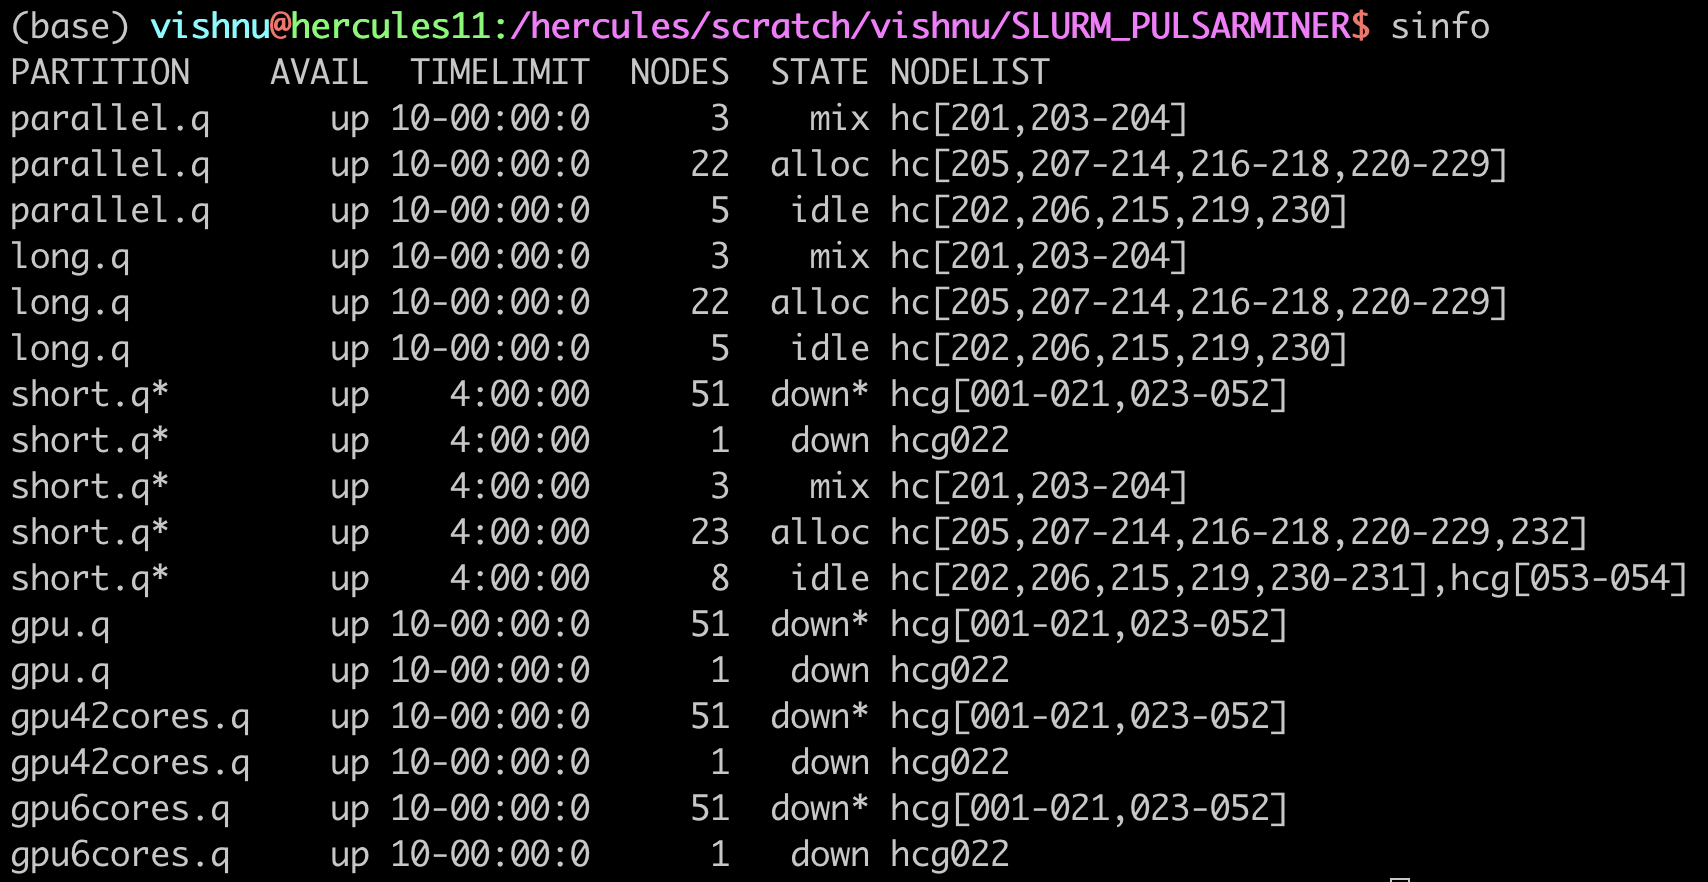

In [4]:
Image(filename='Images/sinfo.png') 


**View the current job queue using squeue**

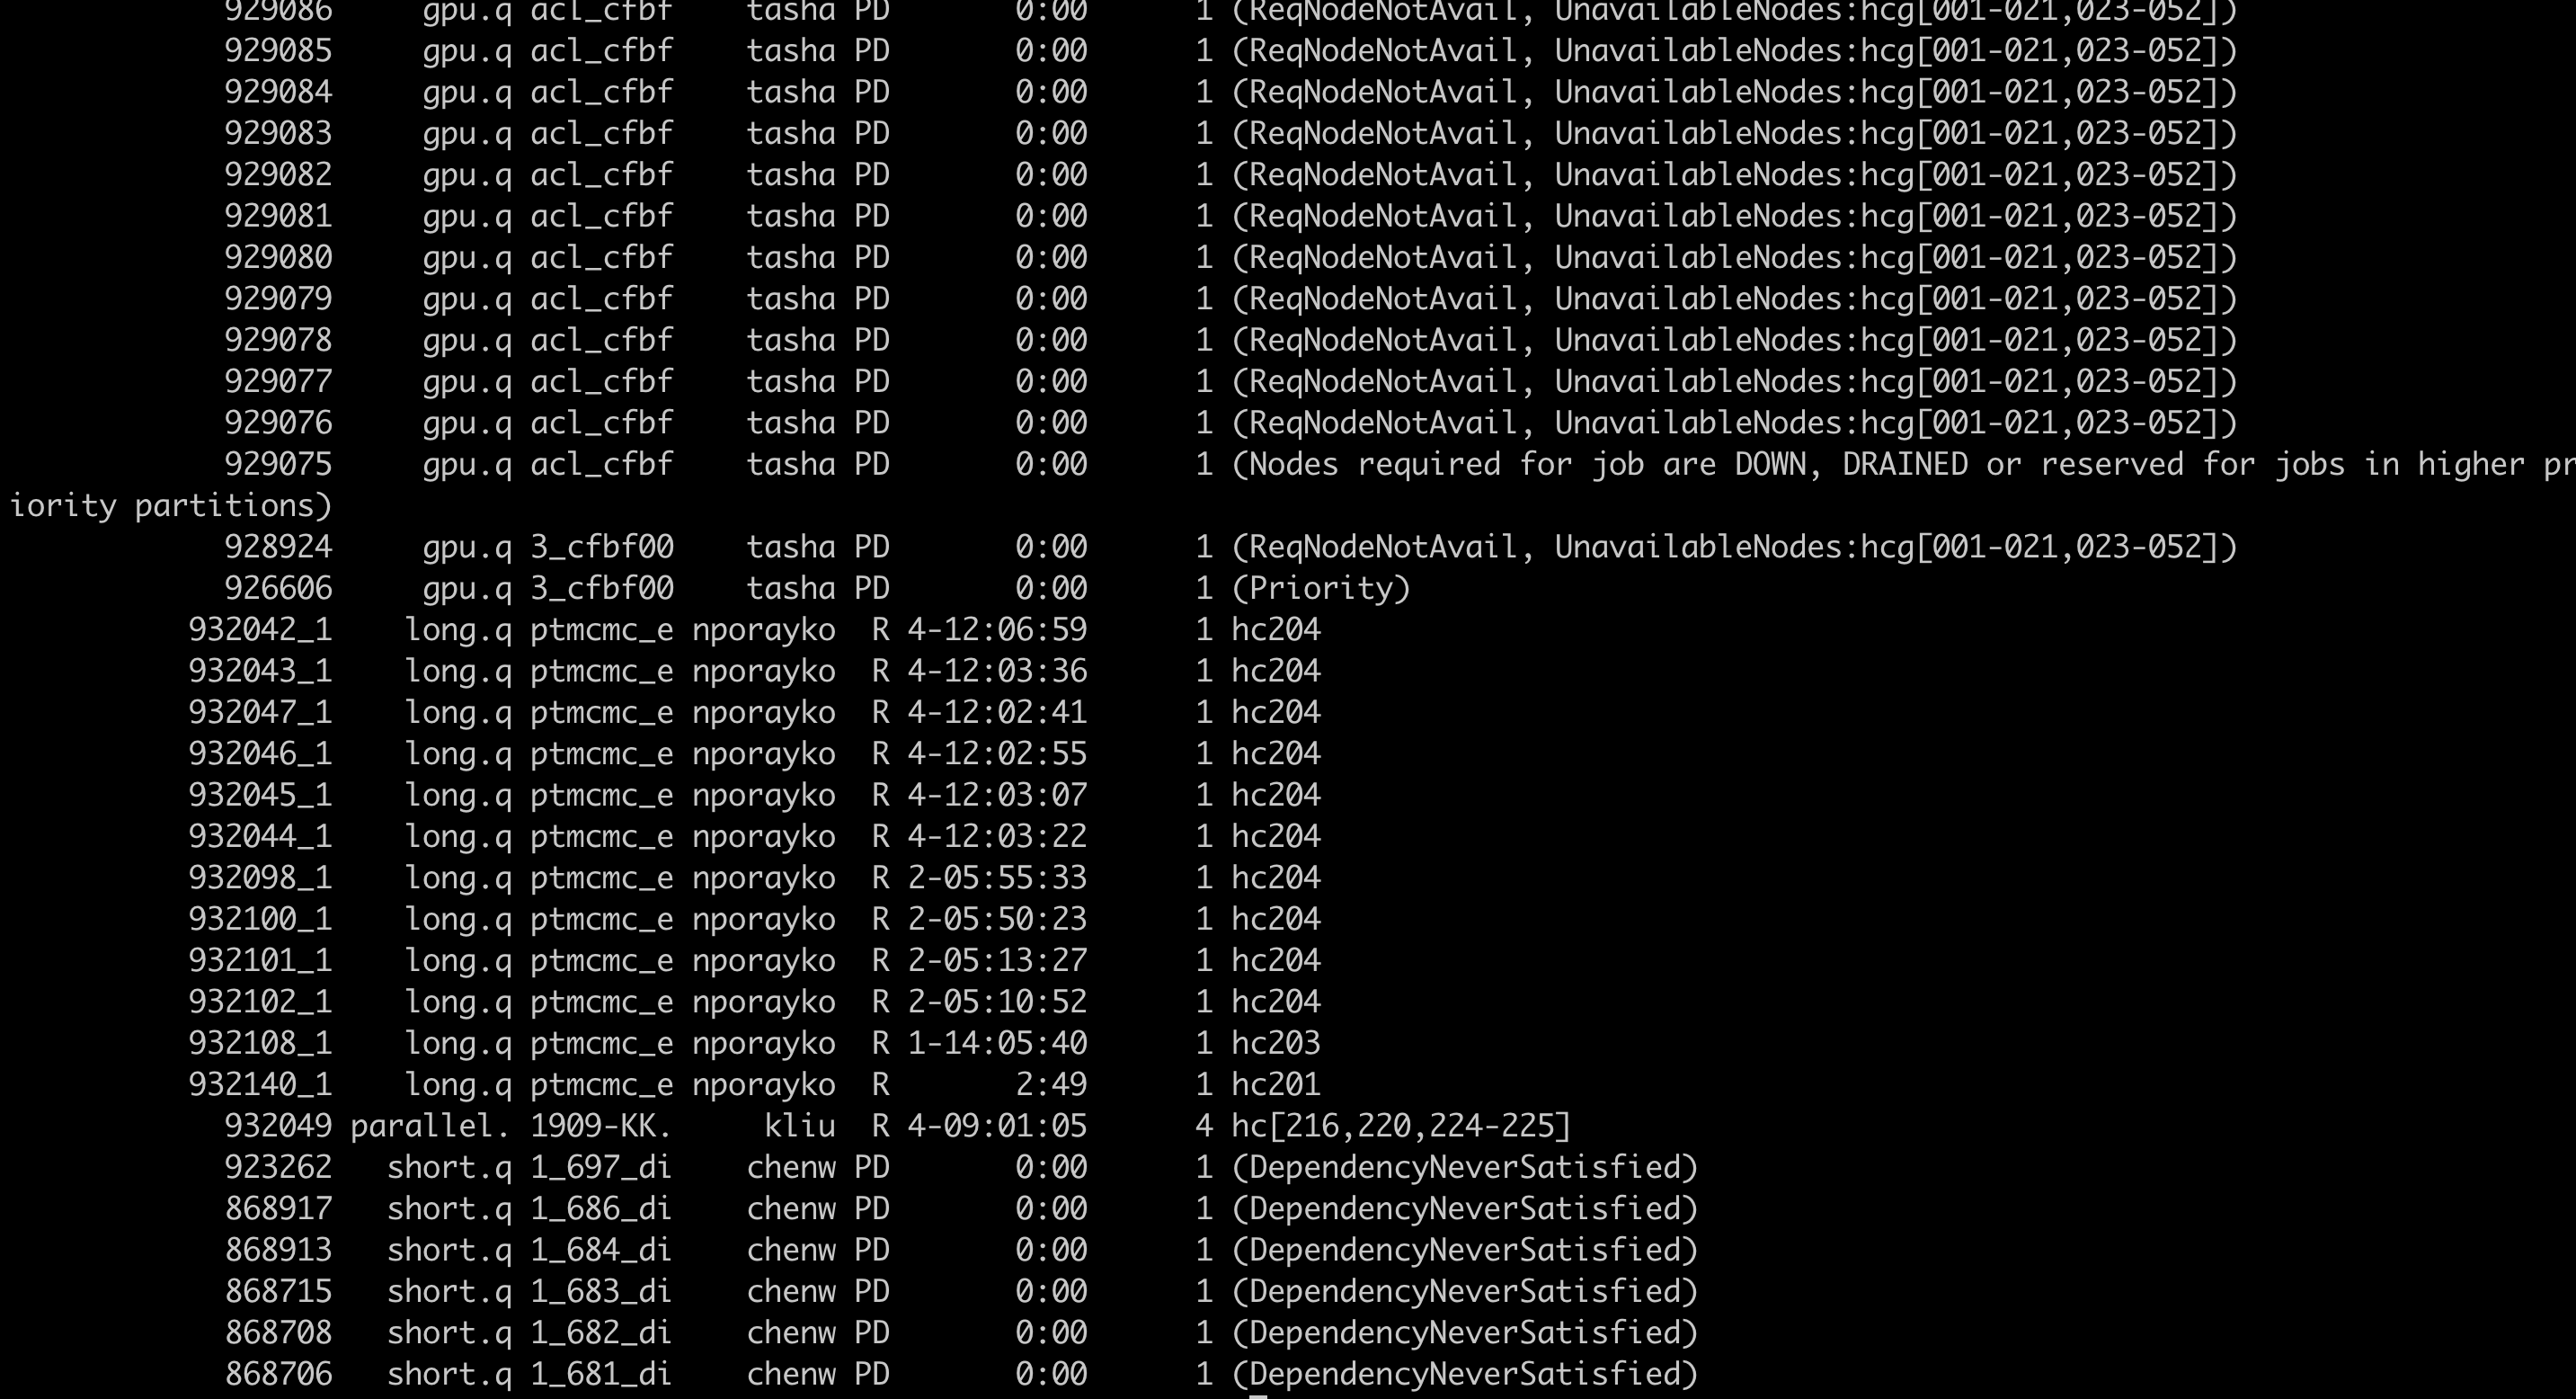

In [5]:
Image(filename='Images/squeue.png') 


**View your available storage quota**

/usr/lpp/mmfs/bin/mmlsquota

In [ ]:
Some helpful things to add to your bashrc

**Now let's start running some slurm jobs**

**First, we start by requesting a single core in a single node for 10 minutes to run a python job**

### Alternative: Slurm inline command

**Task1: Serial Python Job - Word Count Race <br>
Write a simple Python script to count the total number of words in a given text file. You should submit your jobs as serial tasks in Slurm, and the winner is the one whose job finishes first.**

See the word_counter.py script in the Github repo, and read all input files given in the TEXT_FILES directory.

In [ ]:
import sys

def word_count(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
        words = content.split()
        return len(words)

if __name__ == "__main__":
    file_path = sys.argv[1]
    print("Total words in the file:", word_count(file_path))


**Running a parallel job using multiple CPU cores in a single node using slurm and python's multiprocessing library.**

**Task2: Parallel Python Job - Blur Cat and Dog images <br>
Write a simple Python script which can blur images in parallel using multiple CPU cores in a node. The winner is the one whose job finishes first.**

In [ ]:
from PIL import Image, ImageFilter
import sys
import os
import time
from joblib import Parallel, delayed

def process_image(image_path, output_path):
    with Image.open(image_path) as img:
        img = img.filter(ImageFilter.BLUR)
        img.save(os.path.join(output_path, os.path.basename(image_path)))
    time.sleep(30)

if __name__ == "__main__":
    input_dir = sys.argv[1]
    output_dir = sys.argv[2]
    image_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if os.path.isfile(os.path.join(input_dir, f))]

    num_cores = os.cpu_count()
    
    # Execute the code in parallel
    Parallel(n_jobs=num_cores)(delayed(process_image)(image_path, output_dir) for image_path in image_files)

    # Uncomment the following lines to execute the code in serial
    # for image_path in image_files:
    #     process_image(image_path, output_dir)


## What if you need more than one node?

**Task3: Running MPI Jobs that using CPUs from multiple nodes - Calculate value of pi numerically using MCMC <br>
Write a simple Python script which can calculate the value of pi using multiple CPU cores in multiple nodes. The winner is the one calculates the most accurate value within the next 10 minutes.**

If you would like to read more about MPI programming: https://www.uio.no/studier/emner/matnat/ifi/INF3380/v11/undervisningsmateriale/inf3380-week06.pdf

**Here is an example pi_calculation_script that uses python's mpi4py library**

In [ ]:
from mpi4py import MPI
import random
import sys

def calculate_pi(num_points):
    count_inside_circle = 0
    for _ in range(num_points):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        distance = x * x + y * y
        if distance <= 1:
            count_inside_circle += 1
    return count_inside_circle

if __name__ == "__main__":
    num_points = int(sys.argv[1])
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    local_count = calculate_pi(num_points // size)

    global_count = comm.reduce(local_count, op=MPI.SUM, root=0)

    if rank == 0:
        pi = 4 * global_count / num_points
        print("Calculated value of Pi:", pi)

**And below is your slurm launch script**

### Difference between task2 and task3 or in other words what is the difference between OpenMP and MPI?

Here is a nice stackoverflow answer:

OpenMP is a way to program on shared memory devices. This means that the parallelism occurs where every parallel thread has access to all of your data.

You can think of it as: parallelism can happen during execution of a specific for loop by splitting up the loop among the different threads.

MPI is a way to program on distributed memory devices. This means that the parallelism occurs where every parallel process is working in its own memory space in isolation from the others.

You can think of it as: every bit of code you've written is executed independently by every process. The parallelism occurs because you tell each process exactly which part of the global problem they should be working on based entirely on their process ID.

The way in which you write an OpenMP and MPI program, of course, is also very different.

## What if you want to launch several using similar jobs where only the initial value changes?

**Use slurm job arrays**

### SLURM CHEATSHEET

In [2]:
IFrame('Images/slurm_cheat_sheet.pdf', width=1200, height=900)


In [ ]:
#
sinfo
partitions
serial job
parallel job
MPI jobs
job arrays
depdendicies
sprio
control start time of job
get emails.